In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import concurrent
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from concurrent.futures import ThreadPoolExecutor
from IPython.core.display import display, HTML

warnings.filterwarnings("ignore")

In [2]:
# df = None

# def read_csv(url):
#     return pd.read_csv(url, dtype={
#         "CRS_DEP_TIME": str,
#         "DEP_TIME": str,
#         "CRS_ARR_TIME": str,
#         "MONTH": str,
#         "DAY_OF_MONTH": str,
#         "DAY_OF_WEEK": str,
#     })

# with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
#     future_list = []

#     for index in range(1, 13):
#         future = executor.submit(read_csv, f"datasets/airline_arrival_delay/month{index}.csv")
#         future_list.append(future)

#     for future in future_list:
#         try:
#             result = future.result(timeout=20)
#             if df is None:
#                 df = result
#             else:
#                 df = df.append(result)
#         except Exception as e:
#             print("Cannot load", e)

In [3]:
# load dataset
use_columns = [
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "UniqueCarrier",
    "FlightNum",
    "TailNum",
    "CRSElapsedTime",
    "ArrDelay",
    "Origin",
    "Dest",
    "Distance",
    "TaxiIn",
    "TaxiOut",
    "Cancelled",
    "Diverted",
]

df = pd.read_csv("datasets/airline_arrival_delay/2007_light.csv", dtype={
    "Month": str,
    "DayofMonth": str,
    "DayOfWeek": str,
    "DepTime": str,
    "CRSDepTime": str,
    "CRSArrTime": str,
    "FlightNum": str,
    "Diverted": str
}, usecols=use_columns)

def add_prefix(columns, prefix, additional_text=""):
    new_columns = []
    
    for col in columns:
        transform = ''.join([e.capitalize() for e in col.split('_')])
        
        if prefix.lower() == col.lower():
            new_columns.append(f"{prefix}{additional_text}")
        else:
            new_columns.append(f"{prefix}{additional_text}{transform}")
            
    return new_columns

df_carriers = pd.read_csv("datasets/airline_arrival_delay/carriers.csv")
df_carriers.columns = add_prefix(df_carriers.columns, "Carrier")

df_planes = pd.read_csv("datasets/airline_arrival_delay/plane-data.csv")
df_planes.columns = add_prefix(df_planes.columns, "Plane")

df_airports_from = pd.read_csv("datasets/airline_arrival_delay/airports.csv")
df_airports_from.columns = add_prefix(df_airports_from.columns, "Airport", "From")

df_airports_to = pd.read_csv("datasets/airline_arrival_delay/airports.csv")
df_airports_to.columns = add_prefix(df_airports_to.columns, "Airport", "To")

In [4]:
df = pd.merge(df, df_carriers, left_on="UniqueCarrier", right_on="CarrierCode", how="inner")
df = pd.merge(df, df_planes, left_on="TailNum", right_on="PlaneTailnum", how="inner")
df = pd.merge(df, df_airports_from, left_on="Origin", right_on="AirportFromIata", how="inner")
df = pd.merge(df, df_airports_to, left_on="Dest", right_on="AirportToIata", how="inner")

## All columns and their description

1. Year: ~~ 1987-2008 ---- Year doesn't tell any story.
2. Month: ~~ 1-12
3. DayofMonth: ~~ 1-31
4. DayOfWeek: ~~ 1 (Monday) - 7 (Sunday)
5. CRSDepTime: ~~ scheduled departure time (local, hhmm)
6. CRSArrTime: ~~ scheduled arrival time (local, hhmm)
7. UniqueCarrier: ~~ unique carrier code
8. FlightNum: ~~ flight number
9. TailNum: ~~ plane tail number
10. CRSElapsedTime: ~~ in minutes ------ __have negative number__
11. ArrDelay: ~~ arrival delay, in minutes
12. Origin: ~~ origin IATA airport code
13. Dest: ~~ destination IATA airport code
14. Distance: ~~ in miles
15. TaxiIn: ~~ taxi in time, in minutes
16. TaxiOut: ~~ taxi out time in minutes
17. Cancelled: ~~ was the flight cancelled?
18. Diverted: ~~ 1 = yes, 0 = no

## Exploratory Data Analysis

In [5]:
# set labels for dataset
df["IsLate"] = df["ArrDelay"].apply(lambda x: x > 30)
# filter out cancelled flights
df = df[df["Cancelled"] == False]

# drop unnecessary columns
df = df.drop([
    "UniqueCarrier",
    "CarrierCode",
    "TailNum",
    "PlaneTailnum",
    "Origin",
    "AirportFromIata",
    "Dest",
    "AirportToIata",
    "ArrDelay",
    "Cancelled",
    "AirportFromCountry",
    "AirportToCountry",
], axis=1)

__CrsElapsedTime:__ Negative numbers means flying back in time zone (bay ngược múi giờ)

In [6]:
# after filtering unnecessary columns, we now have only 30 features and 1 label
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6824629 entries, 0 to 6866466
Data columns (total 31 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Month               object 
 1   DayofMonth          object 
 2   DayOfWeek           object 
 3   CRSDepTime          object 
 4   CRSArrTime          object 
 5   FlightNum           object 
 6   CRSElapsedTime      float64
 7   Distance            int64  
 8   TaxiIn              int64  
 9   TaxiOut             int64  
 10  Diverted            object 
 11  CarrierDescription  object 
 12  PlaneType           object 
 13  PlaneManufacturer   object 
 14  PlaneIssueDate      object 
 15  PlaneModel          object 
 16  PlaneStatus         object 
 17  PlaneAircraftType   object 
 18  PlaneEngineType     object 
 19  PlaneYear           object 
 20  AirportFrom         object 
 21  AirportFromCity     object 
 22  AirportFromState    object 
 23  AirportFromLat      float64
 24  AirportFromLong     floa

In [7]:
df.describe()

,CRSElapsedTime,Distance,TaxiIn,TaxiOut,AirportFromLat,AirportFromLong,AirportToLat,AirportToLong
count,6.824628e+06,6.824629e+06,6.824629e+06,6.824629e+06,6.824629e+06,6.824629e+06,6.824629e+06,6.824629e+06
mean,1.290265e+02,7.359946e+02,6.810318e+00,1.666909e+01,3.673827e+01,-9.554194e+01,3.673836e+01,-9.554218e+01
std,7.159428e+01,5.721199e+02,5.096006e+00,1.179794e+01,5.753571e+00,1.837888e+01,5.754778e+00,1.838186e+01
min,1.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.770189e+01,-1.766460e+02,1.770189e+01,-1.766460e+02
25%,7.800000e+01,3.250000e+02,4.000000e+00,1.000000e+01,3.343417e+01,-1.119778e+02,3.343417e+01,-1.119778e+02
50%,1.100000e+02,5.870000e+02,6.000000e+00,1.400000e+01,3.750517e+01,-8.997667e+01,3.750517e+01,-8.997667e+01
75%,1.600000e+02,9.650000e+02,8.000000e+00,1.900000e+01,4.077724e+01,-8.131603e+01,4.077724e+01,-8.131603e+01
max,6.600000e+02,4.962000e+03,5.450000e+02,5.300000e+02,7.128545e+01,-6.479856e+01,7.128545e+01,-6.479856e+01


In [8]:
df.describe(include="O").T

,count,unique,top,freq
Month,6824629,12,8,610266
DayofMonth,6824629,31,12,229065
DayOfWeek,6824629,7,1,1019383
CRSDepTime,6824629,1187,600,120648
CRSArrTime,6824629,1397,1930,24877
FlightNum,6824629,7592,1,5147
Diverted,6824629,2,0,6808770
CarrierDescription,6824629,19,Southwest Airlines Co.,1071606
PlaneType,6472829,5,Corporation,6428466
PlaneManufacturer,6472829,35,BOEING,2671998


In [9]:
df.head(5).T

,0,1,2,3,4
Month,1,1,1,3,4
DayofMonth,1,13,29,8,2
DayOfWeek,1,6,1,4,1
CRSDepTime,1420,1205,1905,1205,1955
CRSArrTime,1550,1330,2030,1330,2120
FlightNum,2386,1355,462,1355,80
CRSElapsedTime,90.0,85.0,85.0,85.0,85.0
Distance,479,479,479,479,479
TaxiIn,2,2,3,3,2
TaxiOut,7,7,7,10,9


In [10]:
print(f"Total rows: {len(df)}")

Total rows: 6824629


### Check missing values

In [11]:
# list all columns with their total missing values
nan_summary = df.isnull().sum()
nan_summary

Month                      0
DayofMonth                 0
DayOfWeek                  0
CRSDepTime                 0
CRSArrTime                 0
FlightNum                  0
CRSElapsedTime             1
Distance                   0
TaxiIn                     0
TaxiOut                    0
Diverted                   0
CarrierDescription         0
PlaneType             351800
PlaneManufacturer     351800
PlaneIssueDate        351800
PlaneModel            351800
PlaneStatus           351800
PlaneAircraftType     351800
PlaneEngineType       351800
PlaneYear             351800
AirportFrom                0
AirportFromCity         4899
AirportFromState        4899
AirportFromLat             0
AirportFromLong            0
AirportTo                  0
AirportToCity           4926
AirportToState          4926
AirportToLat               0
AirportToLong              0
IsLate                     0
dtype: int64

In [12]:
# the missing value only 5% which is not really significant => drop all missing value
df = df.dropna()

### Heatmap visualization

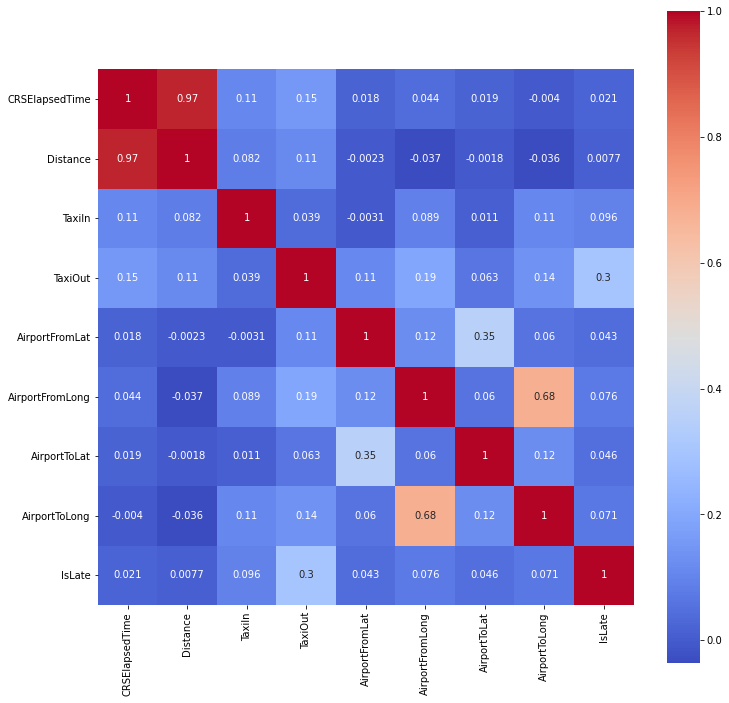

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(df.corr(), annot=True, square=True, cmap="coolwarm", ax=ax);

# the scheduled time & actual time is strictly correlated -> should get the difference
# airtime & distance are also correlated with actual & schedule elapsed time

### Visualization numerical data based on IsLate label

<Figure size 720x504 with 0 Axes>

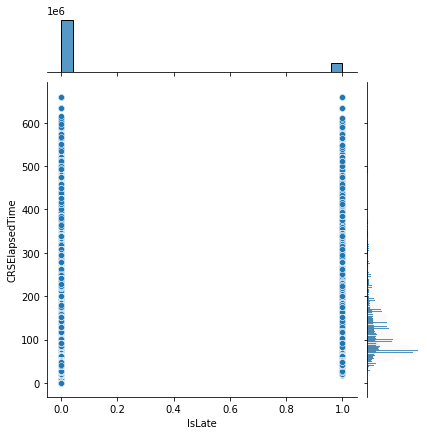

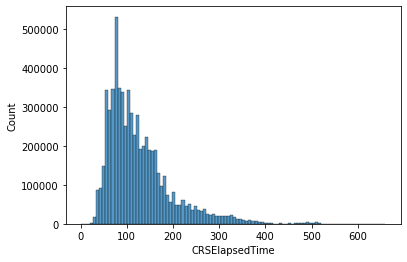

<Figure size 720x504 with 0 Axes>

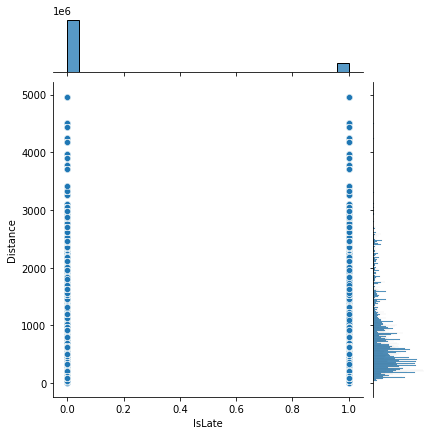

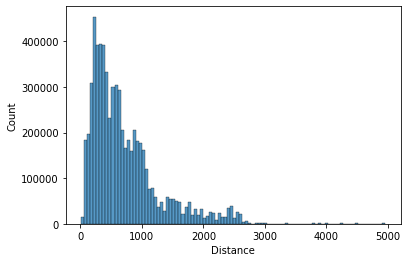

<Figure size 720x504 with 0 Axes>

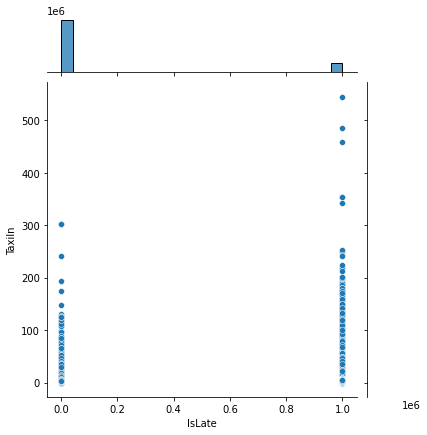

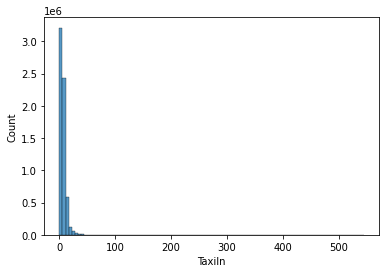

<Figure size 720x504 with 0 Axes>

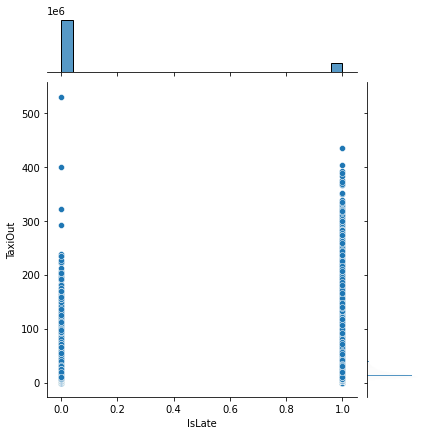

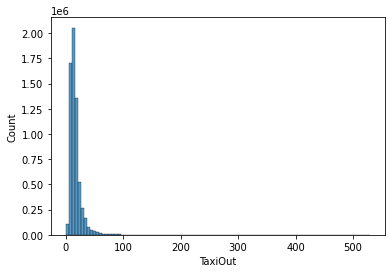

<Figure size 720x504 with 0 Axes>

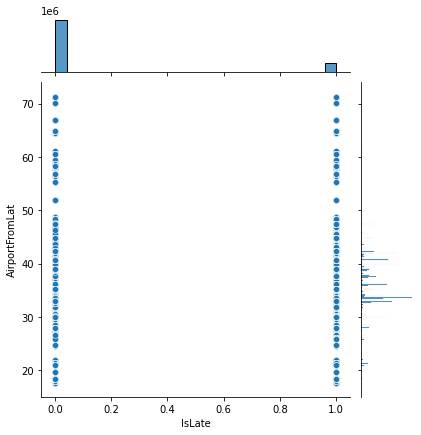

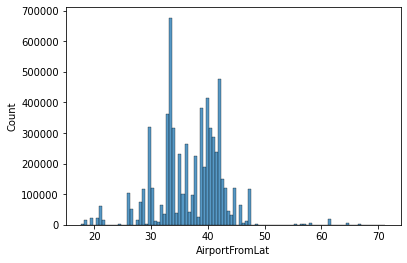

<Figure size 720x504 with 0 Axes>

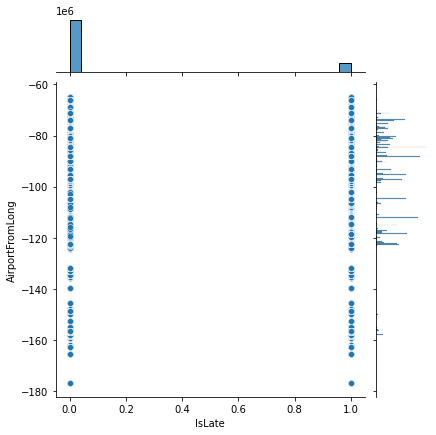

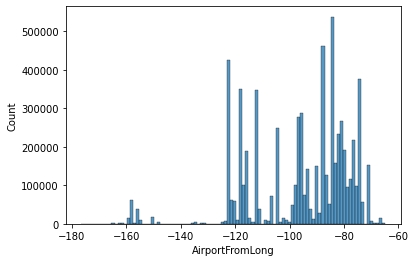

<Figure size 720x504 with 0 Axes>

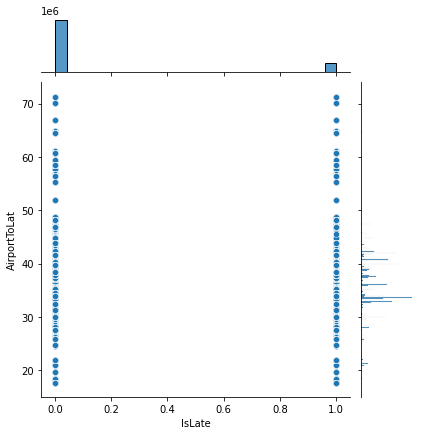

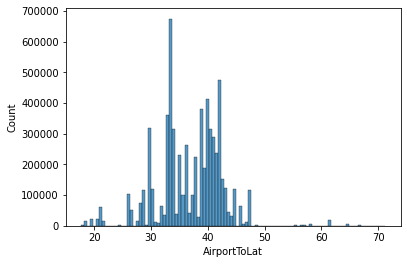

<Figure size 720x504 with 0 Axes>

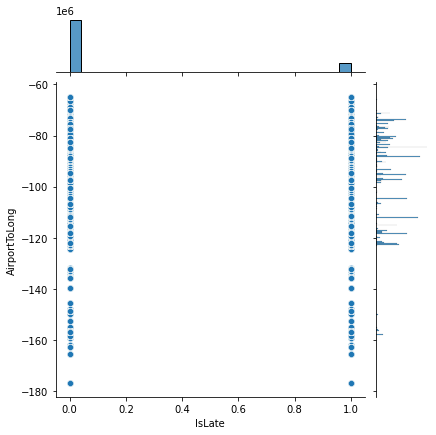

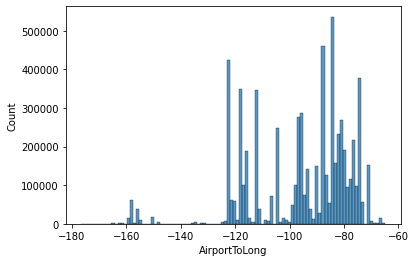

In [14]:
numerical_features = [
    "CRSElapsedTime",
    "Distance",
    "TaxiIn",
    "TaxiOut",
    "AirportFromLat",
    "AirportFromLong",
    "AirportToLat",
    "AirportToLong"
]

for column in numerical_features:
    plt.figure(figsize=(10, 7))
    display(HTML(f"<h4>{column}</h4>"))
    
    sns.jointplot(data=df, x="IsLate", y=column);
    plt.show()
    
    sns.histplot(df[column], bins=100);
    plt.show()

# Via data population, I can see that only the features like TaxiIn, Taxiout affect the lateness directly
# Significantly, distance doesn't show any relation with IsLate

### Visualization categorical data based on IsLate label

In [15]:
df_backup = df.copy()

In [16]:
def split_hour(date):
    return date[:2]

def add_prefix_to_date(day):
    if len(day) == 1:
        return f"0{day}"
    
    return day

def add_prefix_to_time(time):
    return time.rjust(4, "0")

df = df_backup.copy()
df["CRSDepTime"] = df["CRSDepTime"].apply(add_prefix_to_time)
df["CRSArrTime"] = df["CRSArrTime"].apply(add_prefix_to_time)
df["CRSDepTime_Hour"] = df["CRSDepTime"].apply(split_hour)
df["CRSArrTime_Hour"] = df["CRSArrTime"].apply(split_hour)
df["Month"] = df["Month"].apply(add_prefix_to_date)
df["DayofMonth"] = df["DayofMonth"].apply(add_prefix_to_date)
df["Diverted"] = df["Diverted"].map({"0": "Non-diverted", "1": "Diverted"})
df["PlaneIssueYear"] = df["PlaneIssueDate"].apply(lambda e: e.split("/")[-1])

# diverted is all NaN column, so I would drop this feature
df = df.drop(["CRSDepTime", "CRSArrTime", "PlaneIssueDate", "Diverted"], axis=1)

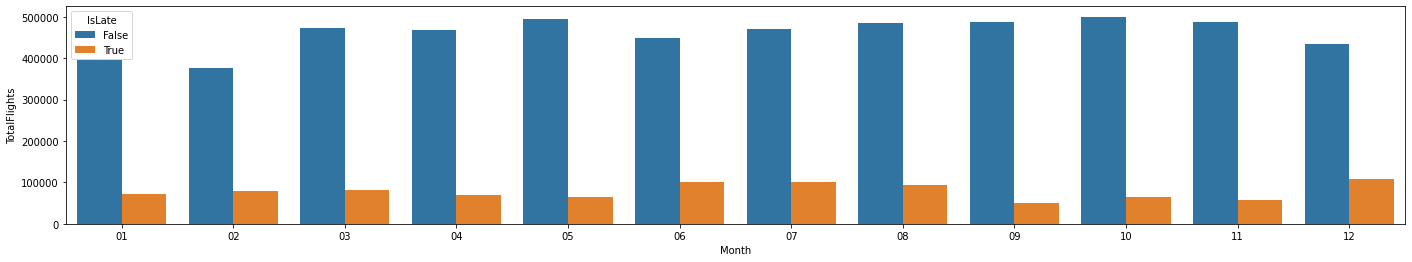

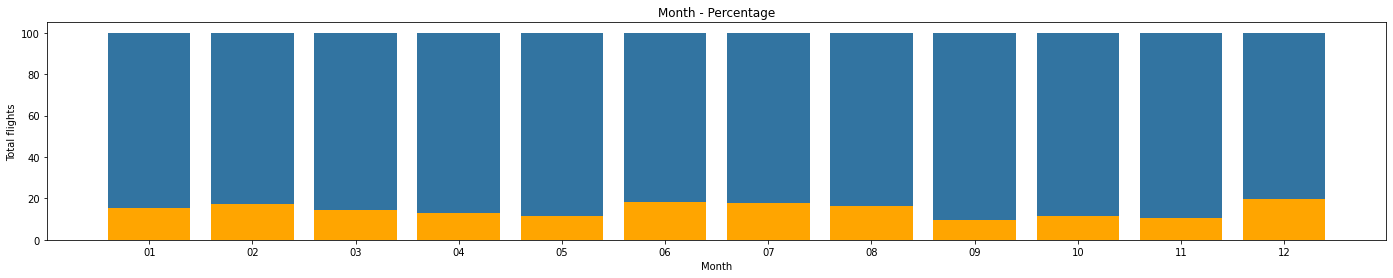

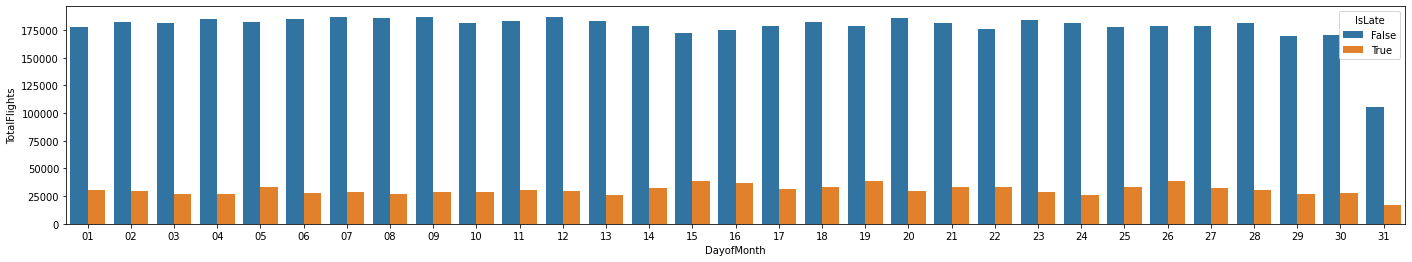

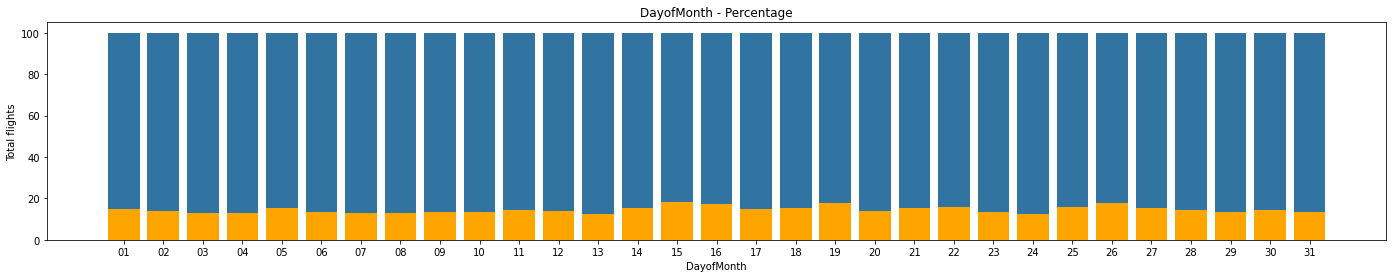

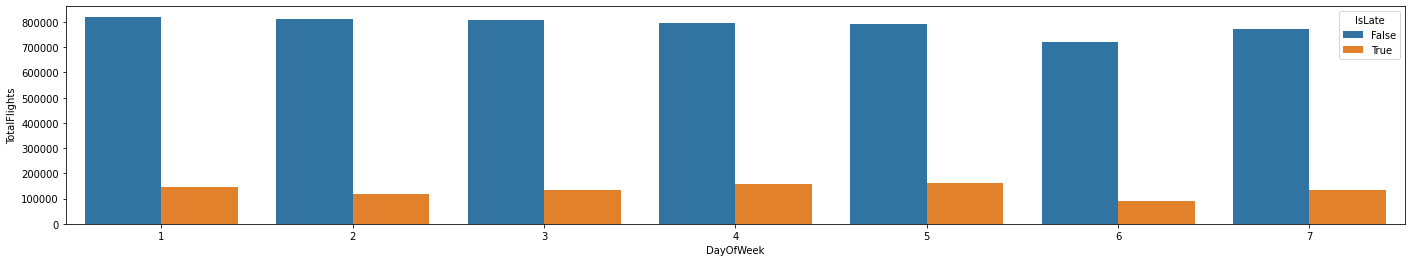

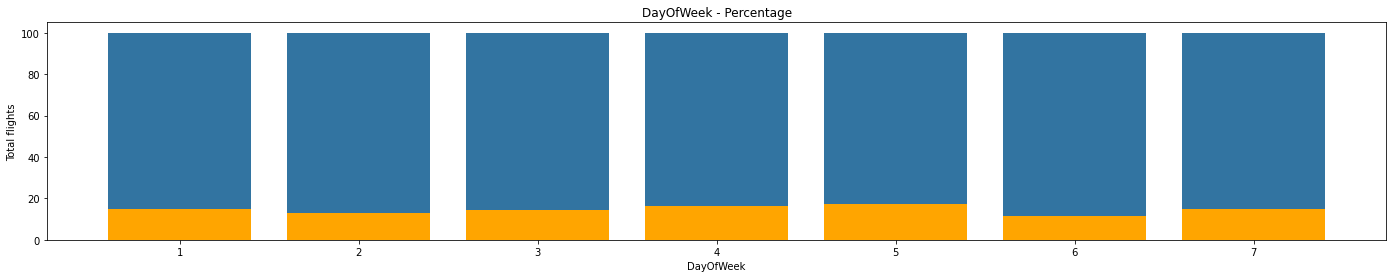

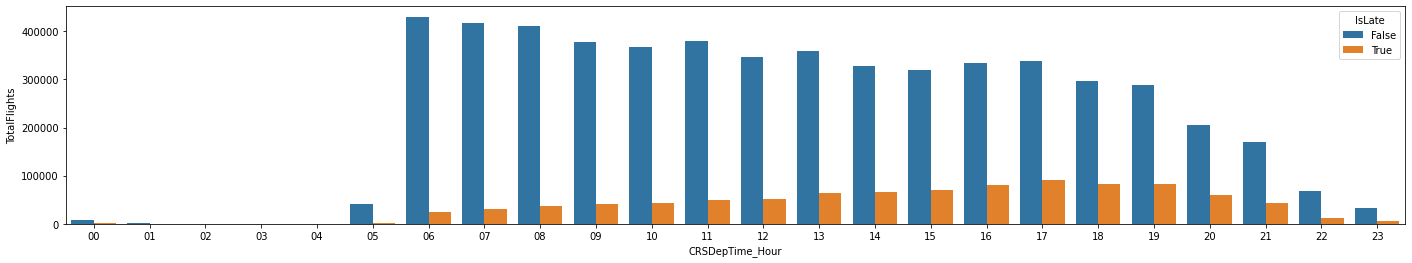

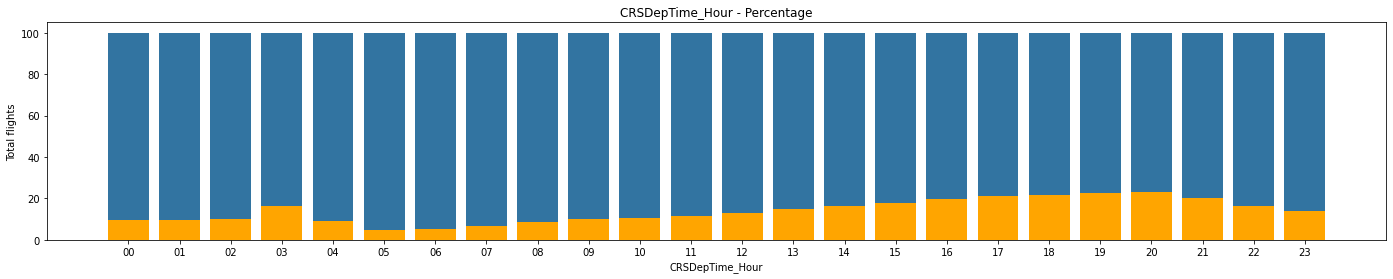

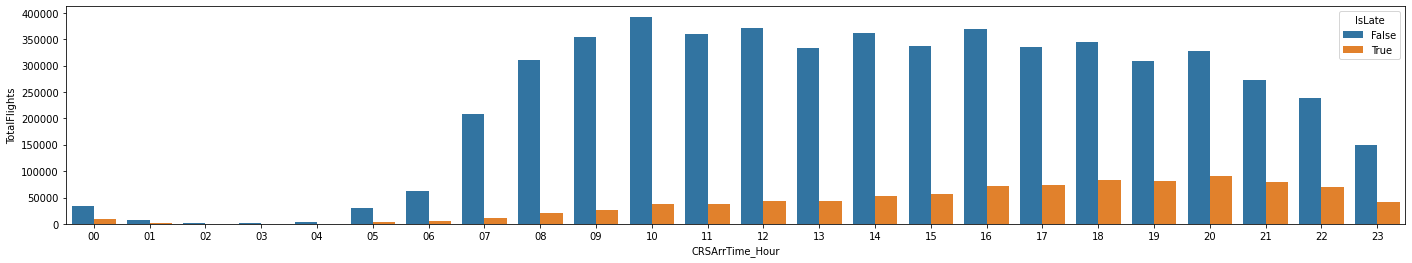

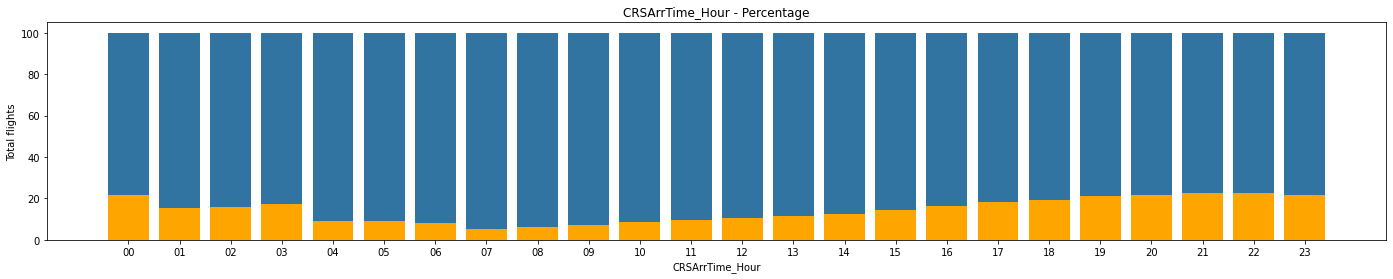

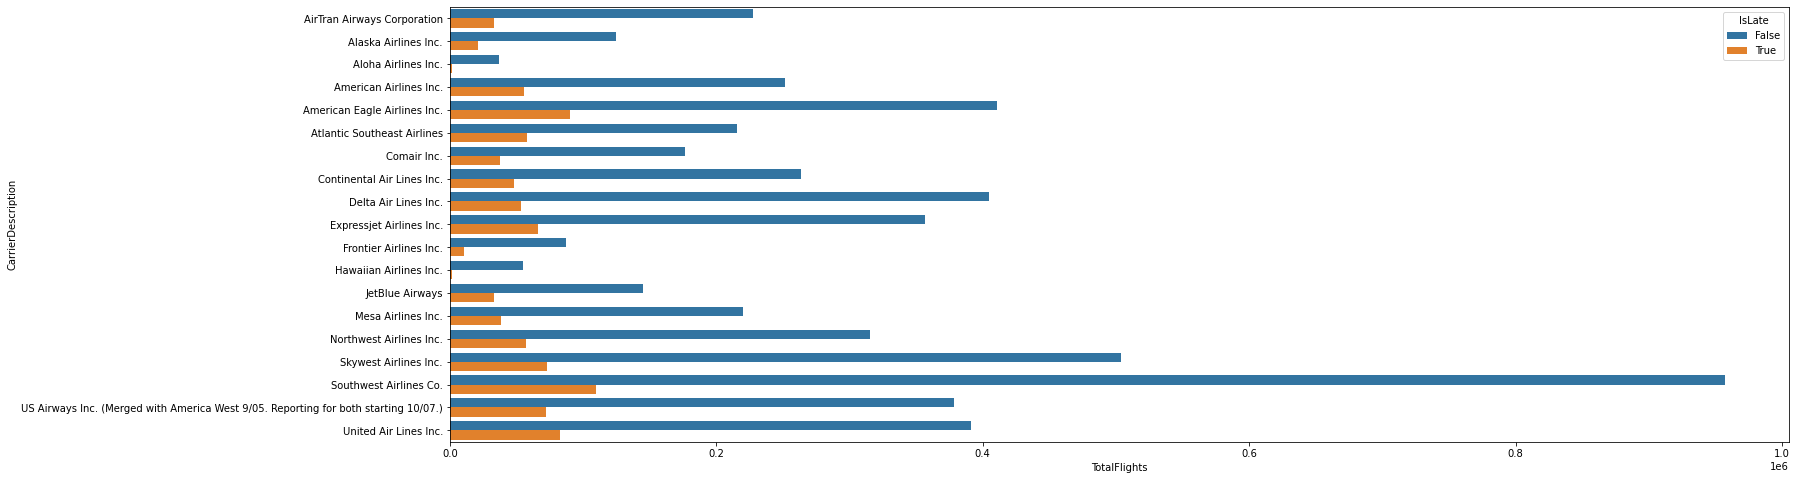

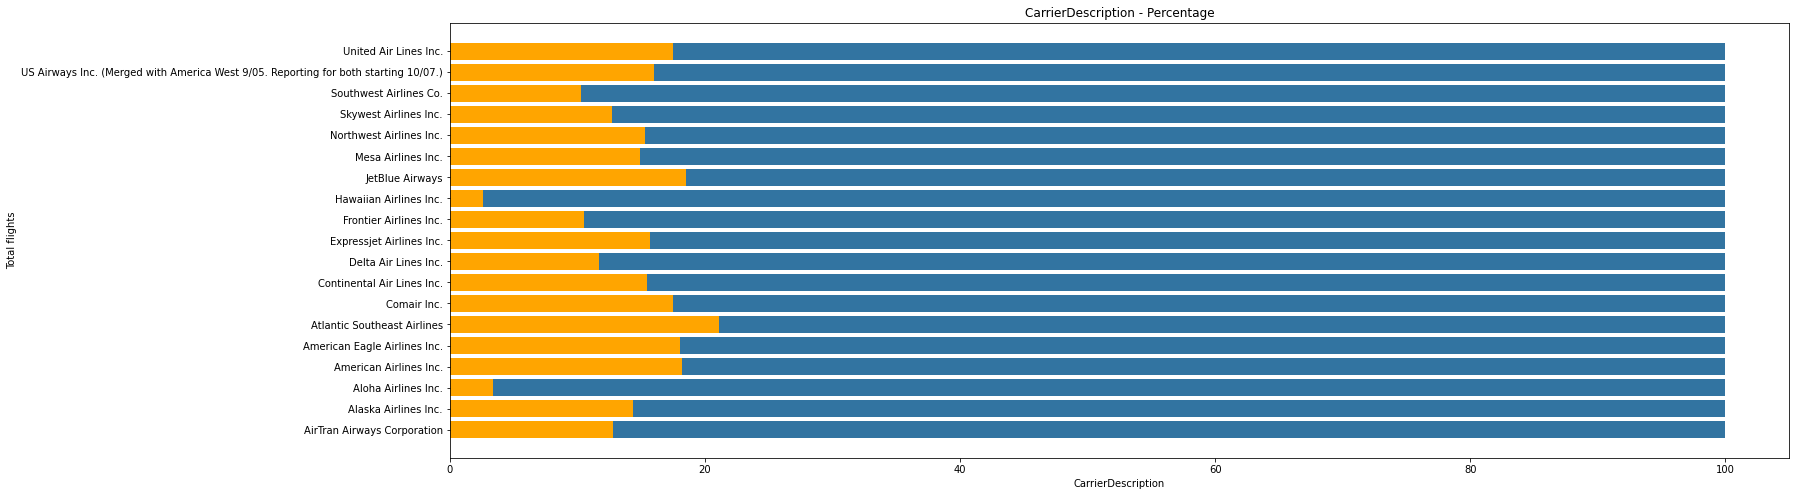

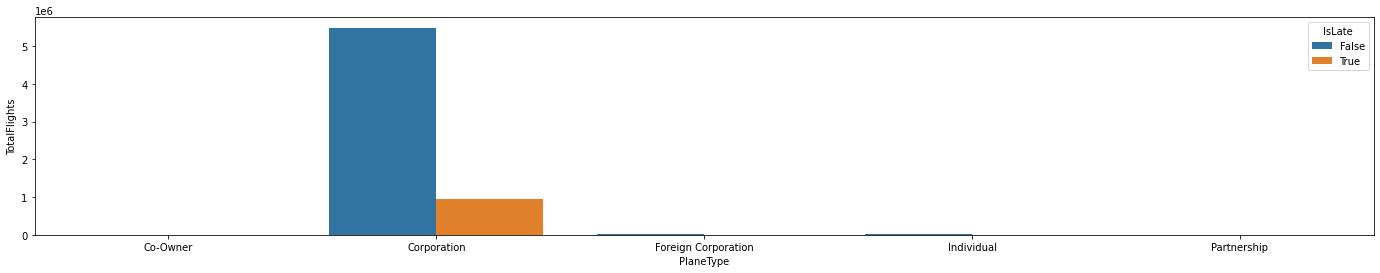

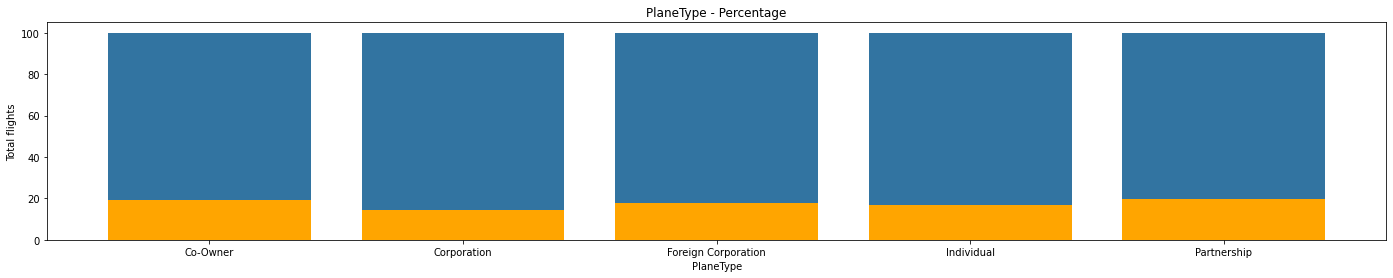

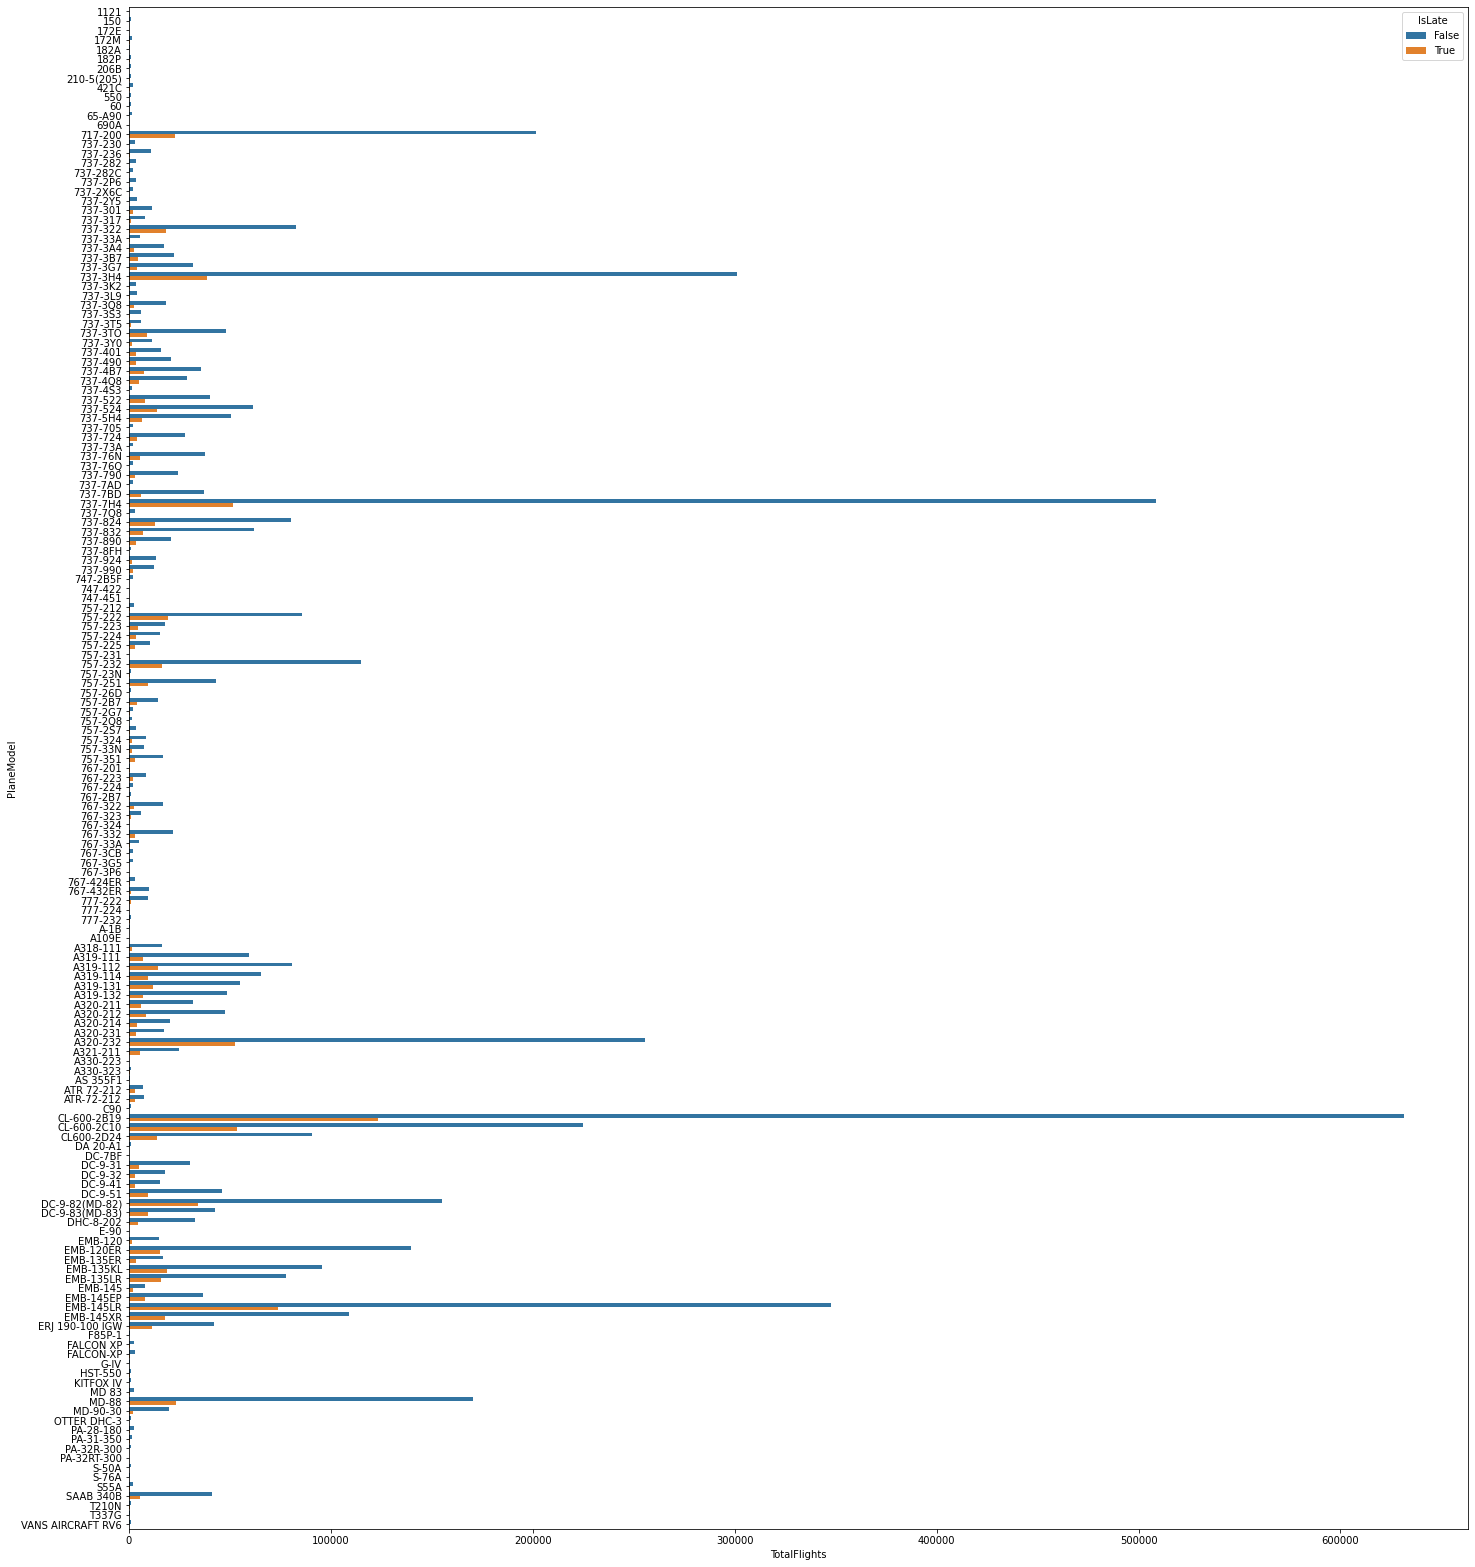

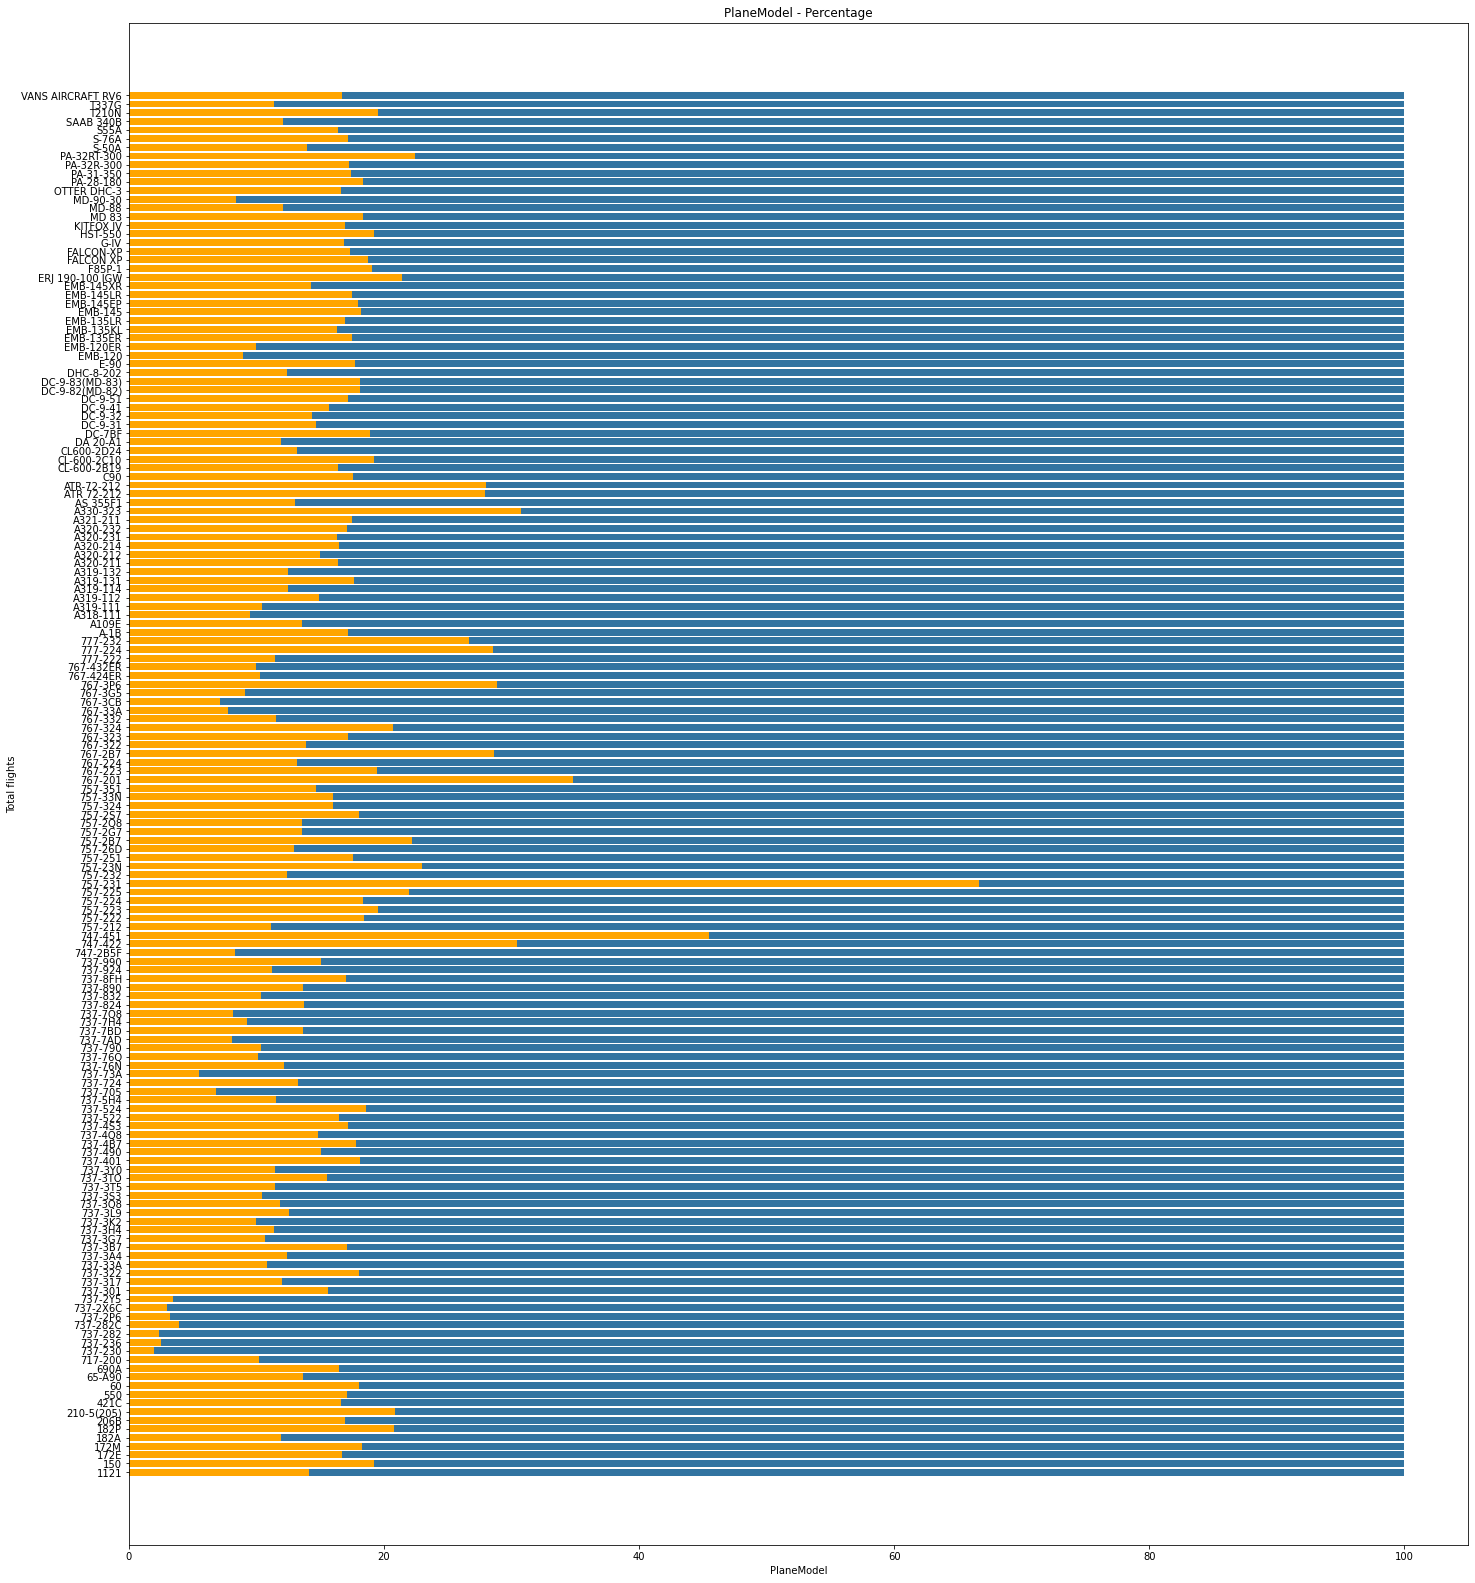

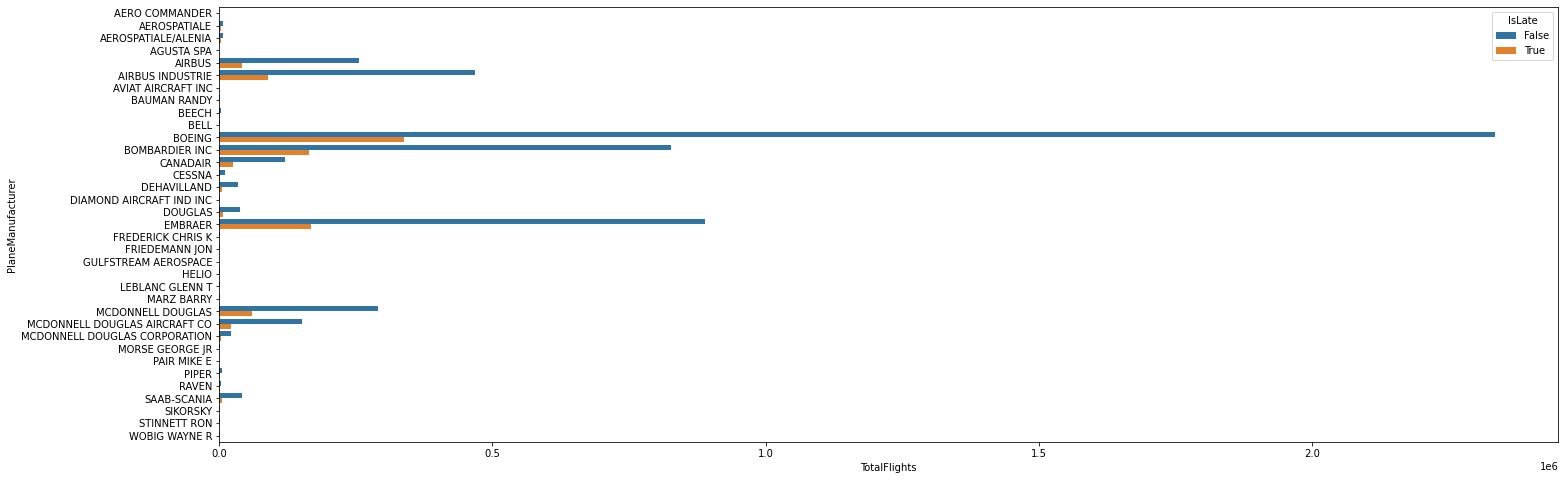

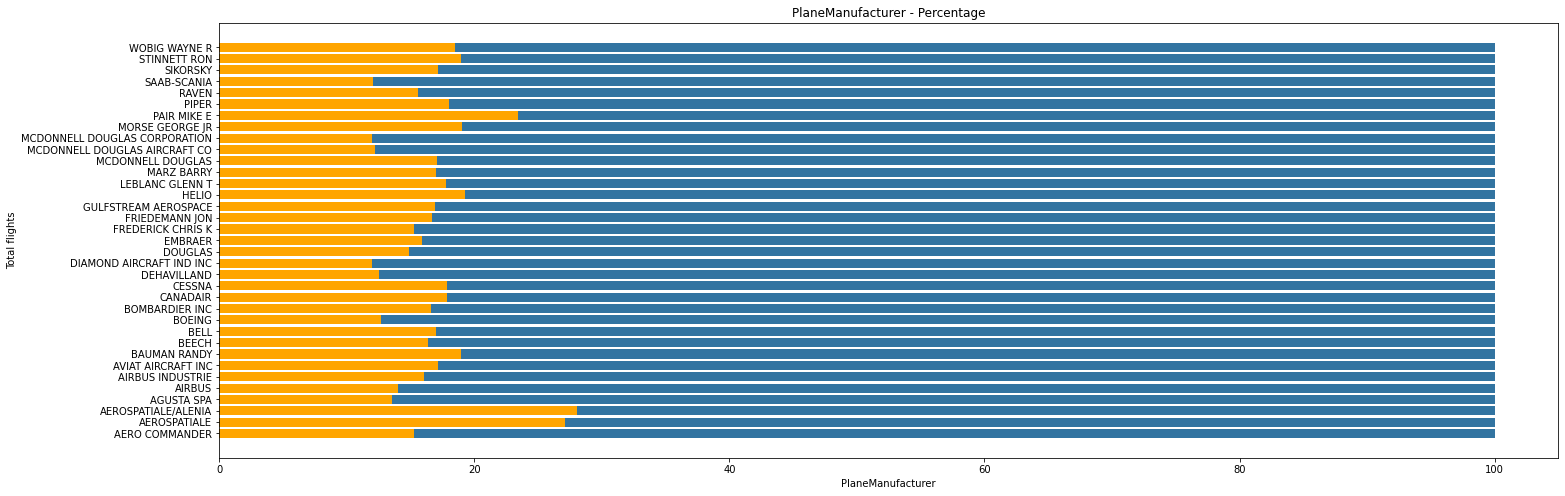

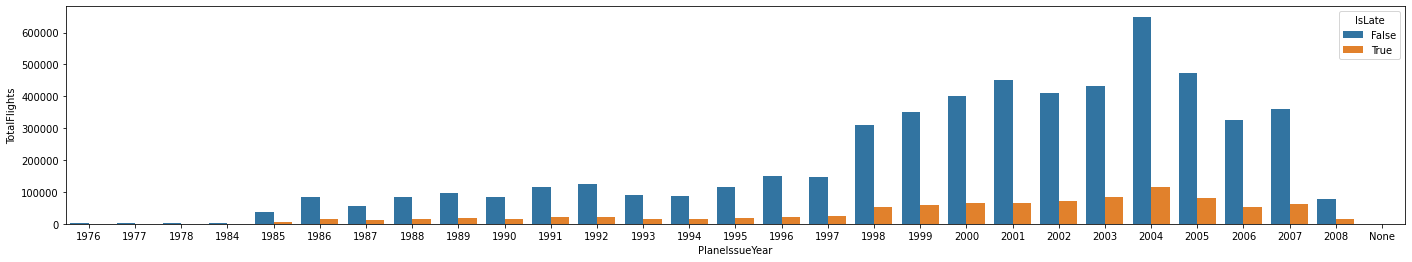

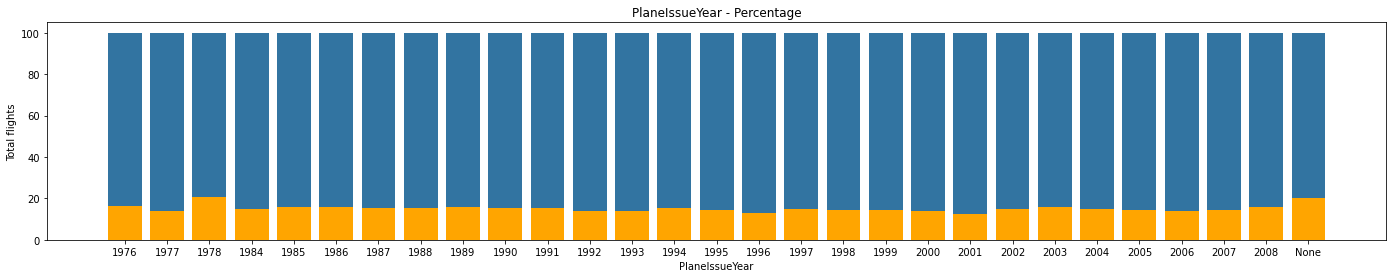

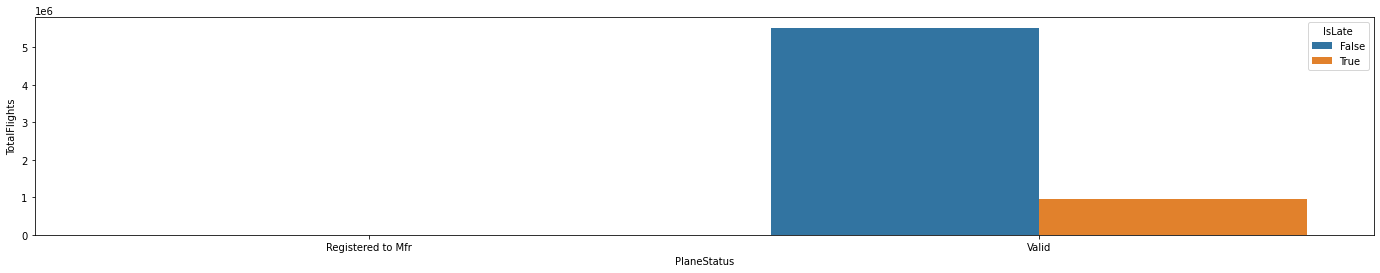

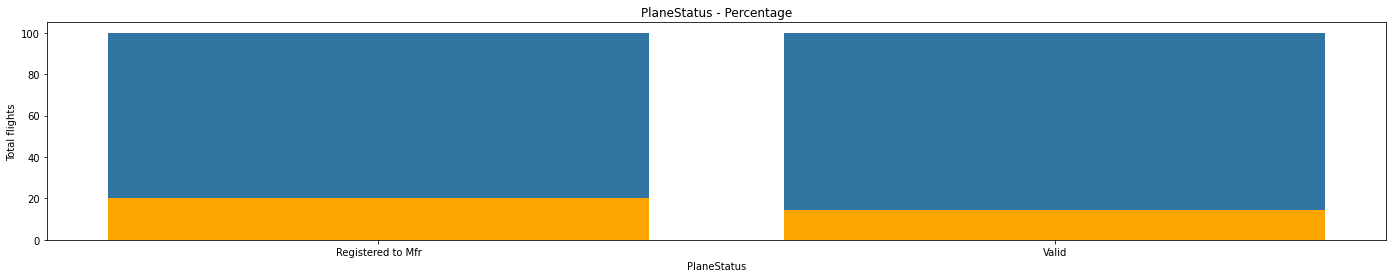

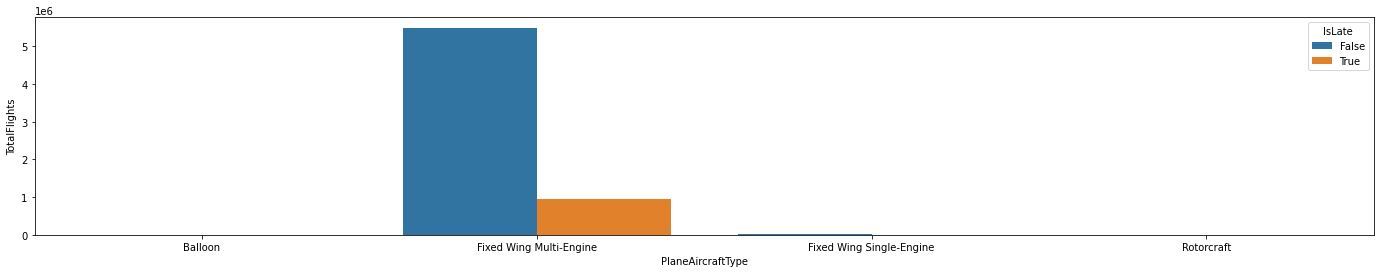

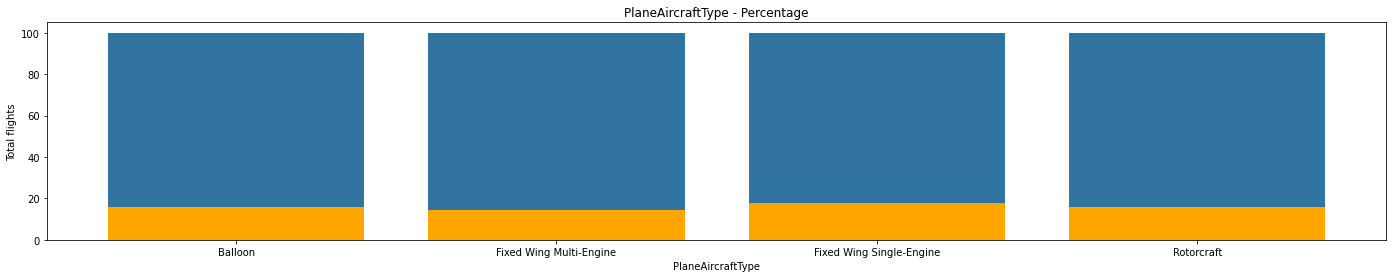

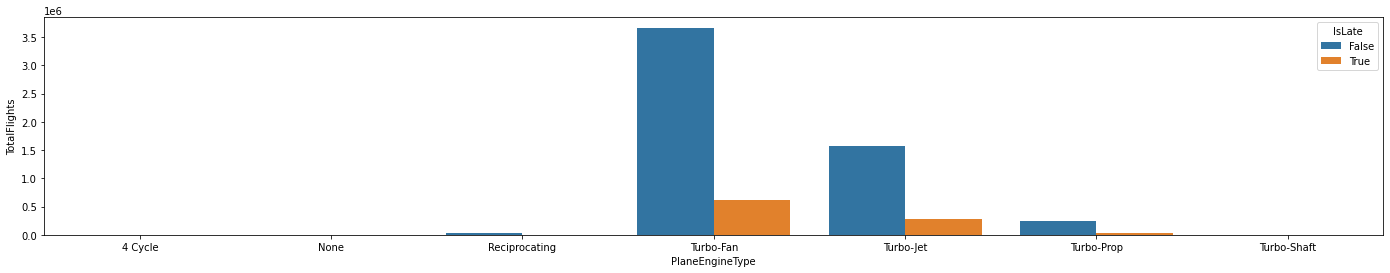

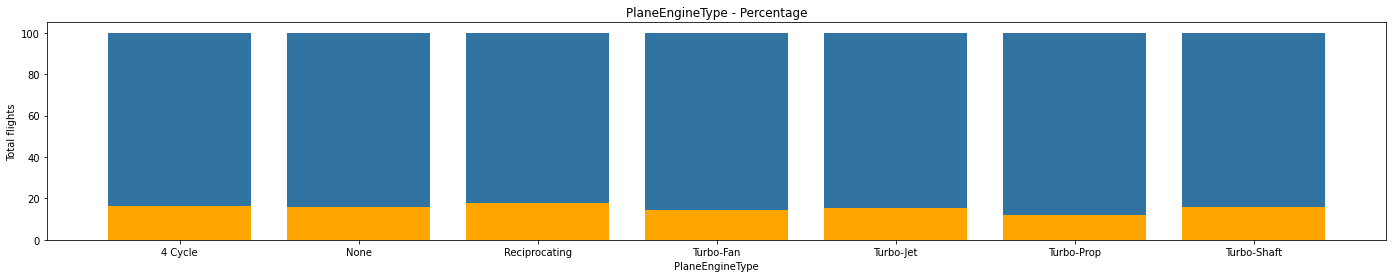

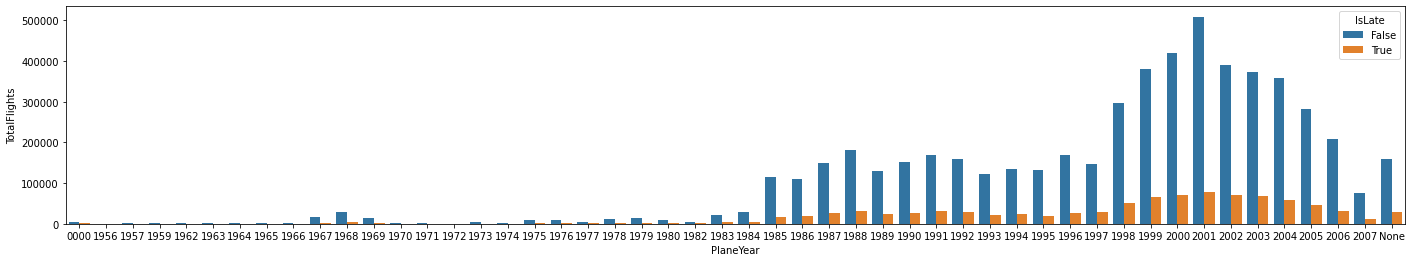

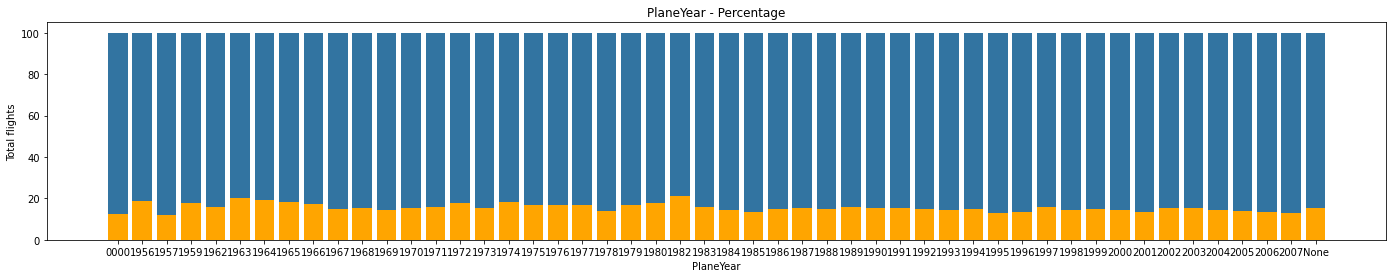

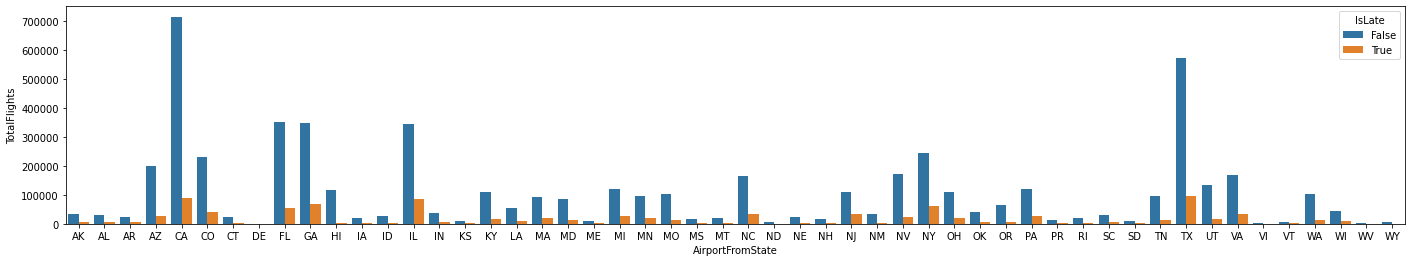

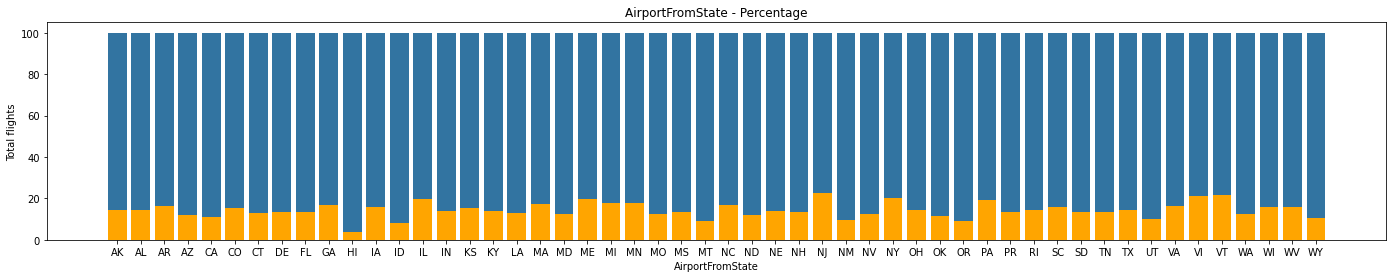

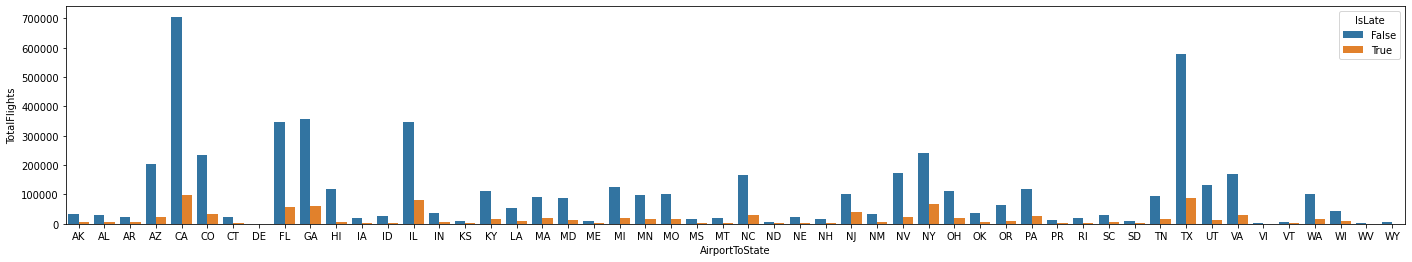

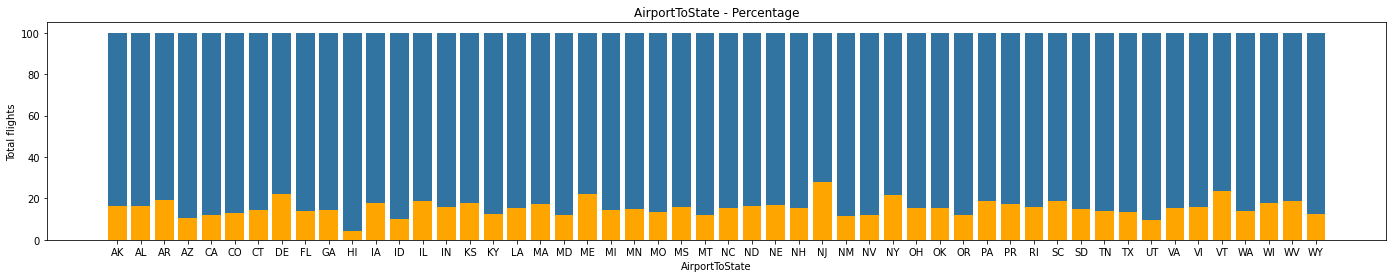

In [23]:
categorical_features = [
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime_Hour",
    "CRSArrTime_Hour",
    "CarrierDescription",
    "PlaneType",
    "PlaneModel",
    "PlaneManufacturer",
    "PlaneIssueYear",
    "PlaneStatus",
    "PlaneAircraftType",
    "PlaneEngineType",
    "PlaneYear",
    "AirportFromState",
    "AirportToState",
]
barh_columns = [
    "PlaneModel",
    "PlaneManufacturer",
    "CarrierDescription"
]

for column in categorical_features:
    visualize, column_values, is_late_percentage, is_not_late_percentage = calculate_categorical_percentage(df, column)
    
    display(HTML(f"<h4>{column}</h4>"))

    # show IsLate percentage
    
    
    if column in barh_columns:
        height = 8 if column != "PlaneModel" else 28
        
        plt.figure(figsize=(24, height))
        sns.barplot(x="TotalFlights", hue="IsLate", y=column, data=visualize);
        plt.show()
        
        plt.figure(figsize=(24, height))
        plt.barh(column_values, is_late_percentage, color="orange")
        plt.barh(column_values, is_not_late_percentage, left=is_late_percentage, color="#3274a1")
    else:
        plt.figure(figsize=(24, 4))
        sns.barplot(x=column, hue="IsLate", y="TotalFlights", data=visualize);
        plt.show()
    
        plt.figure(figsize=(24, 4))
        plt.bar(column_values, is_late_percentage, color="orange")
        plt.bar(column_values, is_not_late_percentage, bottom=is_late_percentage, color="#3274a1")
        
    plt.xlabel(column)
    plt.ylabel("Total flights")
    plt.title(f"{column} - Percentage")
    plt.show()

From the visualized data, we can see that PlaneModel, DayofMonth, CRSDepTime_Hour, CRSArrTime_Hour, Month (4 months), CarrierDescription, PlaneManufacturer, AirportFromState, AirportToState have significant impact to the lateness of Flights.

In contrast, DayOfWeek, PlaneType, PlaneIssueYear, PlaneStatus, AircraftType don't show any promising influence to the lateness

In [39]:
def calculate_categorical_percentage(df, column):
    visualize = df.groupby(column)["IsLate"].value_counts().to_frame()
    visualize["TotalFlights"] = df.groupby(column)["IsLate"].value_counts().values
    visualize = visualize.drop(["IsLate"], axis=1).reset_index()
    
    column_values1 = visualize[visualize["IsLate"] == True][column].unique()
    column_values2 = visualize[visualize["IsLate"] == False][column].unique()
    
    column_values = list(set(column_values1) & set(column_values2))
    
    total_flights = visualize[visualize[column].isin(column_values)].groupby(column)["TotalFlights"].sum()
    is_late = visualize[(visualize["IsLate"] == True) & (visualize[column].isin(column_values))]["TotalFlights"]
    is_not_late = visualize[(visualize["IsLate"] == False) & (visualize[column].isin(column_values))]["TotalFlights"]

    is_late_percentage = [value / total_flights[i] * 100 for i, value in enumerate(is_late)]
    is_not_late_percentage = [value / total_flights[i] * 100 for i, value in enumerate(is_not_late)]
    
    return visualize, column_values, is_late_percentage, is_not_late_percentage

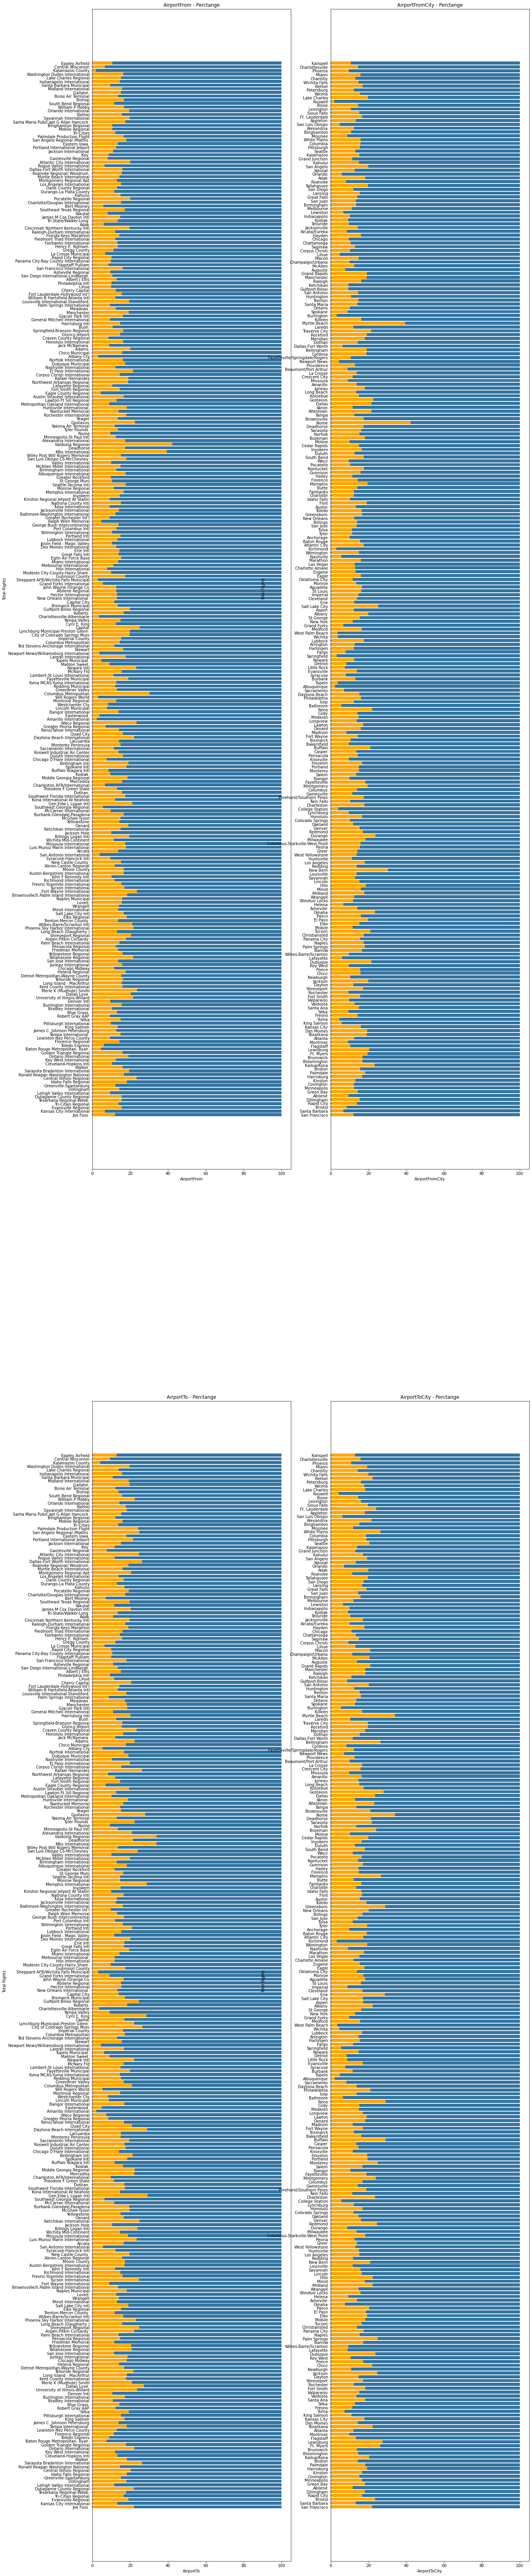

In [45]:
fig, ax = plt.subplots(2, 2, figsize=(20, 120))
columns = [["AirportFrom", "AirportFromCity"], ["AirportTo", "AirportToCity"]]

for index, (column1, column2) in enumerate(columns):
    _, column_values, is_late_percentage, is_not_late_percentage = calculate_categorical_percentage(df, column1)

    ax[index][0].barh(column_values, is_late_percentage, color="orange")
    ax[index][0].barh(column_values, is_not_late_percentage, left=is_late_percentage, color="#3274a1")
    ax[index][0].set_xlabel(column1)
    ax[index][0].set_ylabel("Total flights")
    ax[index][0].set_title(f"{column1} - Perctange")

    _, column_values, is_late_percentage, is_not_late_percentage = calculate_categorical_percentage(df, column2)
    ax[index][1].barh(column_values, is_late_percentage, color="orange")
    ax[index][1].barh(column_values, is_not_late_percentage, left=is_late_percentage, color="#3274a1")
    ax[index][1].set_xlabel(column2)
    ax[index][1].set_ylabel("Total flights")
    ax[index][1].set_title(f"{column2} - Perctange")

plt.show()

<!--  "Origin", "Dest",  -->
According to the data, the late percentage is higher in the winter season (by month) and in the night time. The DayOfWeek doesn't seem to have any impact on the lateness. Furthermore, DayOfMonth also doesn't show a clear effect on the lateness.

The most significant feature here is OpUniqueCarier, the late flights varies depending on this feature, because obviously there are some carriers most of the times depart in incorrected timing.

Besides, origin and dest also contribute to the lateness. Because there are bad and good conditioning airports, large and small area, easily for flights to depart and land, ...

In [18]:
# show 31 days in every month to check when the demands increase
# show the lateness also

### Filter noise & Feature engineering

In [47]:
from scipy import stats

# due to having too manu unique values, we drop AirportFrom, AirportFromCity, AirportTo, AirportToCity, and FlightNum
# similarly, DayOfWeek, PlaneType, PlaneIssueYear, PlaneStatus, and PlaneAircraftType don't show any relation to the lateness
df = df.drop([
    "AirportFrom",
    "AirportFromCity",
    "AirportTo",
    "AirportToCity",
    "FlightNum",
    "DayOfWeek",
    "PlaneType",
    "PlaneIssueYear",
    "PlaneStatus",
    "PlaneAircraftType",
], axis=1)

# Q1,Q3 = np.percentile(sorted(df['Price']),[25,75])
# IQR = Q3 - Q1
# upperlim = Q3 + 1.5*IQR
# lowerlim = max(Q1 - 1.5*IQR,0)

# calculate z-score to filter noise
for feature in numerical_features:
    z_scores = np.abs(stats.zscore(df[feature]))
    df = df[z_scores <= 3]

In [50]:
df = df.drop(["FlightNum"], axis=1)

In [51]:
df.head(5).T

,0,1,2,3,4
Month,01,01,01,03,04
DayofMonth,01,13,29,08,02
CRSElapsedTime,90.0,85.0,85.0,85.0,85.0
Distance,479,479,479,479,479
TaxiIn,2,2,3,3,2
TaxiOut,7,7,7,10,9
CarrierDescription,Southwest Airlines Co.,Southwest Airlines Co.,Southwest Airlines Co.,Southwest Airlines Co.,Southwest Airlines Co.
PlaneManufacturer,BOEING,BOEING,BOEING,BOEING,BOEING
PlaneModel,737-3H4,737-3H4,737-3H4,737-3H4,737-3H4
PlaneEngineType,Turbo-Fan,Turbo-Fan,Turbo-Fan,Turbo-Fan,Turbo-Fan


In [20]:
dummy_columns = ["OpUniqueCarrier"]

for column in dummy_columns:
    df = df.join(pd.get_dummies(df[column], column, drop_first=True))
    
df = df.drop(dummy_columns, axis=1)

In [21]:
# feature engineering
# I see the abnormal from these hours and months, so I decided to create the new features for them
df["IsDepTimeNight"] = df["DepTime_Hour"].isin(["21", "22", "23", "24", "01", "02", "03"])
df["IsCrsArrTimeLateNight"] = df["CrsArrTime_Hour"].isin(["24", "01", "02", "03"])
df["IsRainySeason"] = df["Month"].isin(["12", "01", "02", "03"])

df = df.drop(["DepTime_Hour", "CrsArrTime_Hour", "Month"], axis=1)

In [22]:
df.head(5)

,DepDelay,TaxiIn,Diverted,CrsElapsedTime,Distance,IsLate,OpUniqueCarrier_AA,OpUniqueCarrier_AS,OpUniqueCarrier_B6,OpUniqueCarrier_DL,...,OpUniqueCarrier_NK,OpUniqueCarrier_OH,OpUniqueCarrier_OO,OpUniqueCarrier_UA,OpUniqueCarrier_WN,OpUniqueCarrier_YV,OpUniqueCarrier_YX,IsDepTimeNight,IsCrsArrTimeLateNight,IsRainySeason
0,41.0,4.0,0.0,95.0,363.0,True,0,0,0,0,...,0,0,0,0,1,0,0,False,False,True
0,41.0,4.0,0.0,95.0,363.0,True,0,0,0,0,...,0,0,0,0,0,0,0,False,False,True
0,41.0,4.0,0.0,95.0,363.0,True,1,0,0,0,...,0,0,0,0,0,0,0,False,False,True
0,41.0,4.0,0.0,95.0,363.0,True,0,0,0,0,...,0,1,0,0,0,0,0,False,False,True
0,41.0,4.0,0.0,95.0,363.0,True,0,0,0,0,...,0,0,0,0,1,0,0,False,False,True


In [23]:
from sklearn.model_selection import train_test_split

# month -> RainySeason, DepTime_Hour -> IsDepTimeNight (21 -> 03), CrsArrTime_Hour -> IsCrsArrTimeLateNight (21 -> 03), keep OpUniqueCarrier
# drop DayOfMonth, DayOfWeek, CrsDepTime_Hour

X = df.drop(["IsLate"], axis=1)
y = df["IsLate"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

# because the below features don't illustrate the bell shape --> use min_max_scaling
min_max_scaling_columns = ["DepDelay", "TaxiIn", "CrsElapsedTime", "Distance"]

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train[min_max_scaling_columns])

X_train[min_max_scaling_columns] = min_max_scaler.transform(X_train[min_max_scaling_columns])
X_test[min_max_scaling_columns] = min_max_scaler.transform(X_test[min_max_scaling_columns])

### Train models

#### ROC curve
__Definition:__ a graph showing the performance of a classification model at all classification thresholds. Plot two params:
- True Positive Rate: $ TPR = \frac{TP}{TP + FN} $ (denominator is positivity **True Positive** -> **Positive**, mẫu số là tổng số dương tính)
- False Positive Rate: $ FPR = \frac{FP}{FP + TN} $ (denominator is negativity, **False Positive** -> **Negative**, mẫu số là tổng số âm tính)

__Reference:__ https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

This graph doesn't show any promising result when classifying late or not late flights.

In [30]:
def show_roc_curve_and_calc_precision_recall(y_test, y_pred, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_test,  y_pred_prob)
    auc = roc_auc_score(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"data 1, auc={auc}")
    plt.legend(loc=4)
    plt.show()
    
    P = metrics.precision_score(y_test, y_pred)
    R = metrics.recall_score(y_test, y_pred)
    F = 2 * ((P * R) / (P + R))
    print("Precision:", P)
    print("Recall:", R)
    print("F1 score:", F)

#### Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn import metrics
import time

In [31]:
def train_n_visualize_model(modelClass, X_train, y_train, X_test, y_test):
    start = time.time()

    model = modelClass()
    model.fit(X_train, y_train);

    print("Total time to train model:", time.time() - start)

    test_score = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test).max(axis=1)

    print("Test score:", test_score)
    print("Precision matrix:")
    print(classification_report(y_test, y_pred, target_names=["class 0", "class 1"]))
    
    show_roc_curve_and_calc_precision_recall(y_test, y_pred, y_pred_prob)
    
    importances = None
    
    if isinstance(model, LogisticRegression):
        importances = pd.DataFrame({"Column": X.columns, "Amount": model.coef_[0] }) 
        importances.sort_values("Amount", ascending=False)
    
    return model, y_pred_prob, importances

Total time to train model: 35.016191720962524
Test score: 0.9805856600548273
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.98      0.99      0.99   1534852
     class 1       0.88      0.72      0.80     84415

    accuracy                           0.98   1619267
   macro avg       0.93      0.86      0.89   1619267
weighted avg       0.98      0.98      0.98   1619267



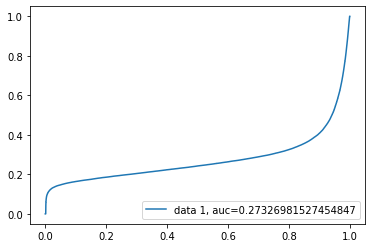

Precision: 0.884143511804629
Recall: 0.7222294615885803
F1 score: 0.7950264391573375


,Column,Amount
0,DepDelay,25.127080
1,TaxiIn,1.917960
2,Diverted,-11.503392
3,CrsElapsedTime,-1.418679
4,Distance,0.636011
5,OpUniqueCarrier_AA,0.076985
6,OpUniqueCarrier_AS,0.056337
7,OpUniqueCarrier_B6,0.056568
8,OpUniqueCarrier_DL,0.055843
9,OpUniqueCarrier_EV,0.039756


In [32]:
model1, _, importances = train_n_visualize_model(LogisticRegression, X_train, y_train, X_test, y_test)
importances

Look at the weights, we can see that the model highly depends on DeDelay feature. We need several techniques to get it out of this situtation

#### Decision Tree

Total time to train model: 42.418152809143066
Test score: 0.9873726815898799
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.99      0.99      0.99   1534852
     class 1       0.88      0.88      0.88     84415

    accuracy                           0.99   1619267
   macro avg       0.94      0.93      0.94   1619267
weighted avg       0.99      0.99      0.99   1619267



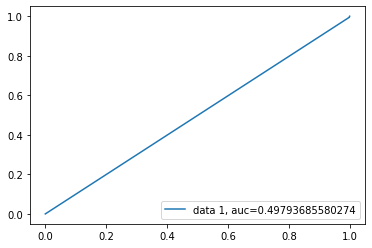

Precision: 0.8810068377290162
Recall: 0.876112065391222
F1 score: 0.8785526339235333


In [35]:
model2, _, importances = train_n_visualize_model(DecisionTreeClassifier, X_train, y_train, X_test, y_test)
importances

#### Naive Bayes

Total time to train model: 5.8425133228302
Test score: 0.25370121172110593
Precision matrix:
              precision    recall  f1-score   support

     class 0       1.00      0.21      0.35   1534852
     class 1       0.06      0.99      0.12     84415

    accuracy                           0.25   1619267
   macro avg       0.53      0.60      0.24   1619267
weighted avg       0.95      0.25      0.34   1619267



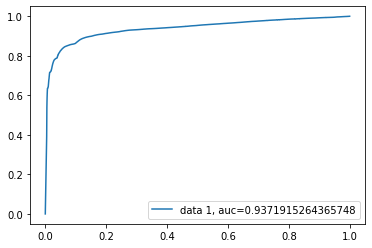

Precision: 0.0647377991734974
Recall: 0.9902387016525499
F1 score: 0.1215304305853498


In [36]:
model3, _, importances = train_n_visualize_model(GaussianNB, X_train, y_train, X_test, y_test)
importances

#### Support Vector Machine

In [ ]:
model4, _, importances = train_n_visualize_model(SVC, X_train, y_train, X_test, y_test)
importances